<a href="https://colab.research.google.com/github/DuongNguyen-ux/practive/blob/main/lap1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# train_fashionmnist.py
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import random
import numpy as np




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------------
# 1) Load FashionMNIST dataset + 2) Apply transforms
# -----------------------------
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),   # nhẹ augmentation để cải thiện generalization
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

labels_map = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"
}








Device: cpu


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.4MB/s]


In [ ]:
# -----------------------------
# 3) Build a neural network (CNN)
# -----------------------------
class CNN_Fashion(nn.Module):
    def __init__(self):
        super(CNN_Fashion, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # -> 32 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # -> 32 x 14 x 14

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> 64 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # -> 64 x 7 x 7

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# -> 128 x 7 x 7
            nn.ReLU(),
            # no further pooling to keep features
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*7*7, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNN_Fashion().to(device)
print(model)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# Utility: evaluate function
# -----------------------------
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    acc = 100.0 * correct / total
    return avg_loss, acc


CNN_Fashion(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
# -----------------------------
# 4) Training loop (forward, loss, backward, optimize)
# -----------------------------
train_losses = []
test_losses = []
test_accuracies = []
epochs = 10
for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}")

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # evaluate on test set after each epoch
    test_loss, test_acc = evaluate(model, test_loader, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch}/{epochs}] Train Loss: {train_loss:.4f} -- Test Loss: {test_loss:.4f} -- Test Acc: {test_acc:.2f}%")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/10] Batch [200/938] Loss: 0.5989
Epoch [1/10] Batch [400/938] Loss: 0.5026
Epoch [1/10] Batch [600/938] Loss: 0.4597
Epoch [1/10] Batch [800/938] Loss: 0.2800
Epoch [1/10] Train Loss: 0.4719 -- Test Loss: 0.3304 -- Test Acc: 88.30%
Epoch [2/10] Batch [200/938] Loss: 0.2512
Epoch [2/10] Batch [400/938] Loss: 0.2634
Epoch [2/10] Batch [600/938] Loss: 0.3364
Epoch [2/10] Batch [800/938] Loss: 0.3411
Epoch [2/10] Train Loss: 0.3014 -- Test Loss: 0.2763 -- Test Acc: 90.05%
Epoch [3/10] Batch [200/938] Loss: 0.2825
Epoch [3/10] Batch [400/938] Loss: 0.1548
Epoch [3/10] Batch [600/938] Loss: 0.2874
Epoch [3/10] Batch [800/938] Loss: 0.2015
Epoch [3/10] Train Loss: 0.2547 -- Test Loss: 0.2606 -- Test Acc: 90.68%
Epoch [4/10] Batch [200/938] Loss: 0.2300
Epoch [4/10] Batch [400/938] Loss: 0.2275
Epoch [4/10] Batch [600/938] Loss: 0.4639
Epoch [4/10] Batch [800/938] Loss: 0.1304
Epoch [4/10] Train Loss: 0.2265 -- Test Loss: 0.2491 -- Test Acc: 90.90%
Epoch [5/10] Batch [200/938] Loss: 0


Final Test Loss: 0.2424, Final Test Accuracy: 92.08%


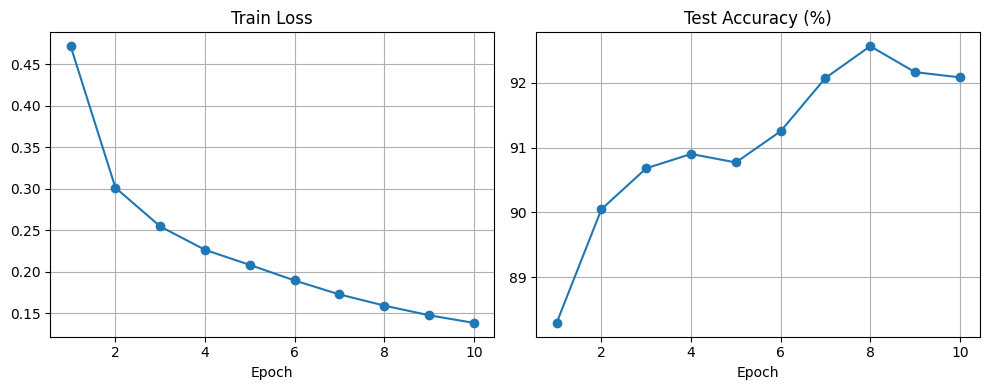

In [ ]:
# -----------------------------
# 5) Final evaluation
# -----------------------------
final_loss, final_acc = evaluate(model, test_loader, device)
print(f"\nFinal Test Loss: {final_loss:.4f}, Final Test Accuracy: {final_acc:.2f}%")

# Plot loss & accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), test_accuracies, marker='o')
plt.title("Test Accuracy (%)")
plt.xlabel("Epoch")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# 6) Save the model
# -----------------------------
model_path = "fashion_cnn.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epochs_trained': epochs,
}, model_path)
print(f"Model saved to {model_path}")

# -----------------------------
# Example: 6b) Load the model (usage)
# -----------------------------
# To load later, create the model instance and load state_dict:
# model = CNN_Fashion()
# checkpoint = torch.load("fashion_cnn.pth", map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # nếu cần resume training
# model.to(device)
# model.eval()

Model saved to fashion_cnn.pth
